# RIS Monte Carlo Simulation for Poly Di-Methyl Siloxane (PDMS)

In [3]:
import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
from math import sin, cos, atan, pi,e, radians as rad
from multiprocessing import Pool
from scipy import stats

!pip install progressbar2
import progressbar

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
num_atoms = 100
num_chains = 100 # 10^4
counter = [0] * 3
initial_temp=300
final_temp=700
rate = 40

In [0]:
#@title Constants
bl={}
ba=[]
ta=[]
ep={}
epo={}
Ua=np.matrix([])
Ub=np.matrix([])

def initializeConstants():
  global bl 
  bl= {
      "si-o": 164,
      "si-c": 190
  }

  global ba
  ba= [143, 110]

  global ta 
  ta= [180, 60, -60]

  global ep 
  ep= {
      "sigma": 0.286,
      "sigma`": 0.286,
      "delta": 0.06
  }

  global epo
  epo= {
      "sigma": 1,
      "sigma`": 1,
      "delta": 1
  }

  global Ua
  Ua= np.matrix([
      [1, ep['sigma'], ep['sigma']],
      [1, ep['sigma`'], 0],
      [1, 0, ep['sigma`']]
  ])

  global Ub
  Ub= np.matrix([
      [1, ep['sigma'], ep['sigma']],
      [1, ep['sigma'], ep['delta']],
      [1, ep['delta'], ep['sigma`']]
  ])
    
initializeConstants()

In [6]:
#@title Next State Calculation
# Conformational states -> trans: 0, gauche+: 1, gauche-: 2

u1 = np.matrix("1, 0, 0")
un = np.matrix("1; 1; 1")
mp = np.linalg.matrix_power

zn = (u1 * mp(Ua * Ub, int((num_atoms-2)/2)) * un)[0, 0]
print(zn)
  
def getPn(i, prev_state, req_state = -1):
  pn = 0
  n = num_atoms
  
  def get_u_dash(u_dash):
    if req_state != -1:
      val = u_dash[prev_state, req_state]
      u_dash.fill(0)
      u_dash[prev_state, req_state] = val
    else:
      val = u_dash[:, prev_state].copy()
      u_dash.fill(0)
      u_dash[:, prev_state] = val
    return u_dash
  
  if i % 2 == 0:
    pn = (u1 * mp(Ua * Ub, int((i-2)/2)) * get_u_dash(Ua.copy()) * Ub * mp(Ua * Ub, int((n-i-2)/2)) * un)[0, 0]
  else:
    pn = (u1 * mp(Ua * Ub, int((i-3)/2)) * Ua * get_u_dash(Ub.copy()) * mp(Ua * Ub, int((n-i-1)/2)) * un)[0, 0]
    
  return pn/zn

def getNextState(i, prev_state):
  from random import random
  rand = random()

  p_ep_t_i = getPn(i, prev_state, 0) # req_state = Trans
  p_ep_i1 = getPn(i-1, prev_state)
  q_t = p_ep_t_i / p_ep_i1
    
  if rand < q_t:
    # print("Next predicted state: Trans")
    return 0 # Trans
  
  p_ep_g_plus_i = getPn(i, prev_state, 1) # req_state = Gauche+
  q_g_plus = p_ep_g_plus_i / p_ep_i1
    
  if rand > q_t and rand < (q_t + q_g_plus):
   #  print("Next predicted state: Gauche+")
    return 1 # Gauche+
  else:
    # print("Next predicted state: Gauche-")
    return 2 # Gauche-

8.632580008221907e+16


In [0]:
#@title Next point coordinates calculation
"""
  p1: point of the previous bond
  p2: current bond's starting point
  p3: current bond's end point
  theta: rotation angle for new bond
  Ref: http://paulbourke.net/geometry/rotate/
"""

def calc_cordinates(p1, p2, p3, new_state, ba):
  inv = np.linalg.inv
  
  t = np.matrix([
      [1, 0, 0, -p2[0]],
      [0, 1, 0, -p2[1]],
      [0, 0, 1, -p2[2]],
      [0, 0, 0, 1,]
  ])
  
  p4 = p3-p2
  p5 = np.sqrt(sum(p4**2))
  a, b, c = p4/p5
  d = np.sqrt(b**2+c**2)
  
  if d != 0:
    cost = c/d
    sint = b/d

    rx = np.matrix([
        [1, 0, 0, 0],
        [0, cost, -sint, 0],
        [0, sint, cost, 0],
        [0, 0 ,0 ,1]
    ])

  ry = np.matrix([
      [d, 0, -a, 0],
      [0, 1, 0, 0],
      [a, 0, d, 0],
      [0, 0, 0, 1],
  ])
  
  p1 = np.append(p1, 1)
  trans_p1 = np.matrix(p1).T
  if d != 0:
    trans_p1 = (ry * rx * t * trans_p1)
  else:
    trans_p1 = (ry * t * trans_p1)
  
  angle = atan(trans_p1[0]/trans_p1[1])
  
  if trans_p1[1] < 0:
    angle = pi - angle
    
  rz = np.matrix([
      [cos(angle), -sin(angle),	0,	0,],
      [sin(angle), cos(angle), 0, 0],
      [0, 0, 1,	0],
      [0,	0, 0, 1]
  ])
  
  trans_p1 = rz * trans_p1
  
  l = bl['si-o']  
  x = abs(l * cos(rad(ba-90)) * sin(rad(ta[new_state])))
  y = abs(l * cos(rad(ba-90)) * cos(rad(ta[new_state])))
  z = l + abs(l * cos(rad(180-ba)))

  if trans_p1[1] < 0:
    if new_state == 1:
      y = -y
    elif new_state == 2:
      x = -x
      y = -y
  else:
    if new_state == 1:
      x = -x
    elif new_state == 0:
      y = -y
      
  newp = np.matrix([[x], [y], [z], [1]])
  if d != 0:
    newp = inv(t) * inv(rx) * inv(ry) * inv(rz) * newp
  else:
    newp = inv(t) * inv(ry) * inv(rz) * newp

  return np.squeeze(np.asarray(newp))[:3]

In [9]:
def generateChains(nc, na, i):
    r = []
    s = []
    cn = [1, 0, 0]
    l = bl['si-o']
    p1_ = np.array([0, 0, 0])
    p2_ = np.array([0, 0, l])
    p3_ = np.array([0, l*sin(rad(37)), (l*cos(rad(37))) + l])
    for j in progressbar.progressbar(range(nc)):
#     for j in range(nc):
        p1 = p1_
        p2 = p2_
        p3 = p3_
        next_state = 0
        chain = [p1, p2, p3]
        for i in range(3, na):
            newp = calc_cordinates(p1, p2, p3, next_state, ba[i%2])
            chain.append(newp)
            p1 = p2
            p2 = p3
            p3 = newp
            next_state = getNextState(i, next_state)
            cn[next_state] += 1
        cm = np.average(chain, axis=0)
        s.append(np.sqrt(np.sum((chain - cm)**2)/num_atoms))
        r.append(np.sqrt(sum(chain[-1]**2)))
    return (r, s, cn)

r = []
s = []
num_process = 2
p = Pool(num_process)
async_results = []
for i in range(num_process):
    async_results.append(p.apply_async(generateChains, (int(num_chains/num_process), num_atoms, i)))
for res in async_results:
    part_r, part_s, cn = res.get()
    r += part_r
    s += part_s
    print(cn)
    counter = list(map(sum, zip(counter,cn)))

100% (50 of 50) |########################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (50 of 50) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


[3419, 688, 744]
[3444, 716, 691]


Average Radius of Gyration: 1539.095803 pm


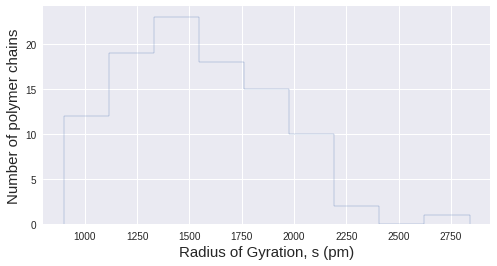

In [10]:
#@title End-to-End distance and Radius of Gyration calculation

print("Average Radius of Gyration: %f pm" % np.average(s))

n_bins = 'auto'
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(s, n_bins, histtype='step')
ax.set_xlabel('Radius of Gyration, s (pm)')
ax.set_ylabel('Number of polymer chains')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

Characteristic ratio: 6.019435


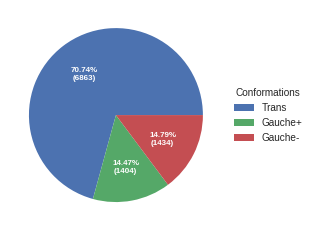

In [11]:
#@title Trans/Guache+- Pie Chart
print("Characteristic ratio: %f" % (sum(np.array(r)**2)/(num_chains * num_atoms * bl['si-o']**2)))

fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))
labels = ["Trans", "Gauche+", "Gauche-"]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.2f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(counter, autopct=lambda pct: func(pct, counter), textprops=dict(color="w"))

ax.legend(wedges, labels, title="Conformations", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

plt.show()

742.4442895880329


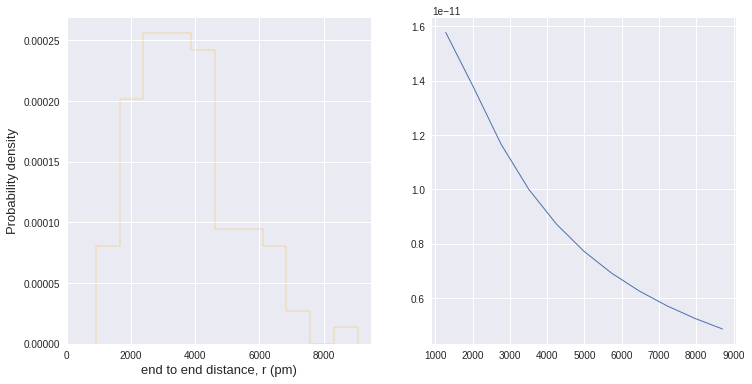

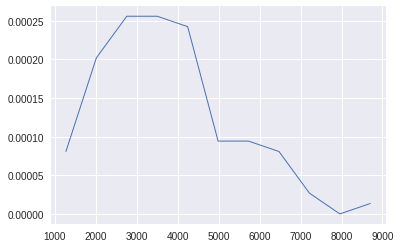

In [12]:
#@title Histogram characterstic ratio probability dist

n_bins = 'auto'
fig, (ax, ax1) = plt.subplots(1,2,figsize=(12, 6))
n, bins, patches = ax.hist(r, n_bins, histtype='step',density=1,color='orange')
ax.set_xlabel('end to end distance, r (pm)')
ax.set_ylabel('Probability density')
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
ax.set_xlim(0)

mid_r =[]
prob_r = []
bin_size = bins[1]-bins[0]
print(bin_size)
next_mid = bins[0]+(bin_size/2)
for i in range(len(bins)-1):
    mid_r.append(next_mid)
    prob_r.append(bins[i]/((4*pi*(((next_mid + bin_size)**3)-(next_mid**3)))*bin_size))
    next_mid += bin_size
    
ax1.plot(mid_r,prob_r,linewidth = 1)
plt.show()
plt.plot(mid_r,n,linewidth = 1)
plt.show()

# Probability distribution
# n, bins, patches = ax1.hist(prob_r, n_bins, histtype='step',density=1)
# ax1.set_xlabel('end to end distance, r (pm)')
# ax1.set_ylabel('Probability distribution')
# ax1.xaxis.label.set_size(13)
# ax1.yaxis.label.set_size(13)
# ax1.set_xlim(5e7)
# plt.show(fig)
# plt.hist(r, n_bins, histtype='step',density=1,color='orange')
# plt.hist(r, n_bins, histtype='step',density=1,color='orange')
# plt.show()


In [0]:
#@title Tests
a = np.array([-1530.13459007, -1804.99708476, -1289.38866144])
b = np.array([-1433.95766567, -1684.88880396, -1346.13370615])
c = np.array([-1511.31658388, -1540.76512889, -1334.30306551])
d = np.array([-1579.9043184 , -1421.24174368, -1423.21809832])

def calc_angle(a, b, c):
  ba = a - b
  bc = c - b

  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  angle = np.arccos(cosine_angle)
  return np.degrees(angle)

def calc_dist(a, b):
  return np.sqrt(sum((a-b)**2))

print(calc_dist(a, b))
print(calc_dist(b, c))
print(calc_dist(c, d))
print(calc_angle(a, b, c))
print(calc_angle(b, c, d))

In [0]:
#@dependency with temperature

def calcR2(nc, na, i):
    r2 = []
    l = bl['si-o']
    p1_ = np.array([0, 0, 0])
    p2_ = np.array([0, 0, l])
    p3_ = np.array([0, l*sin(rad(37)), (l*cos(rad(37))) + l])
    for j in range(nc):
        p1 = p1_
        p2 = p2_
        p3 = p3_
        next_state = 0
        for i in range(3, na):
            newp = calc_cordinates(p1, p2, p3, next_state, ba[i%2])
            p1 = p2
            p2 = p3
            p3 = newp
            next_state = getNextState(i, next_state)
        r2.append(sum(p3**2))
    return r2


# updating with change in temperatures
def updateWeights(temp):
    initializeConstants()
    epw = e**((1/343)-(1/temp))
    global ep, Ua, Ub, zn
    ep['sigma']=ep['sigma']*epw
    ep['delta']=ep['delta']*epw
    ep['sigma`']=ep['sigma`']*epw
#     print (ep['sigma']," | ",ep['sigma`']," | ",ep['delta'])
    Ua = np.matrix([
        [1, ep['sigma'], ep['sigma']],
        [1, ep['sigma`'], 0],
        [1, 0, ep['sigma`']]
    ])
    Ub = np.matrix([
        [1, ep['sigma'], ep['sigma']],
        [1, ep['sigma'], ep['delta']],
        [1, ep['delta'], ep['sigma`']]
    ])
    zn = (u1 * mp(Ua * Ub, int((num_atoms-2)/2)) * un)[0, 0]
#     print("Zn=" + str(zn))

def changeTemp() :
    avg_r=[]
    temp_r=[]
    for temp in progressbar.progressbar(range(initial_temp,final_temp,rate)):
        r2 = []
        updateWeights(temp)
        num_process = 2
        p = Pool(num_process)
        async_results = []
        for i in range(num_process):
            async_results.append(p.apply_async(calcR2, (int(num_chains/num_process), num_atoms, i)))
        for res in async_results:
            r2 += res.get()
        avg_r.append(np.log(np.average(r2)))
        temp_r.append(temp)
#     print(avg_r, temp_r)
    return avg_r,temp_r

In [15]:
avg_r, temp_r = changeTemp()

100% (10 of 10) |########################| Elapsed Time: 0:01:28 Time:  0:01:28


Slope of fitted line: 0.0002889089980036404
Intercept of fitted line: 16.348669238756713


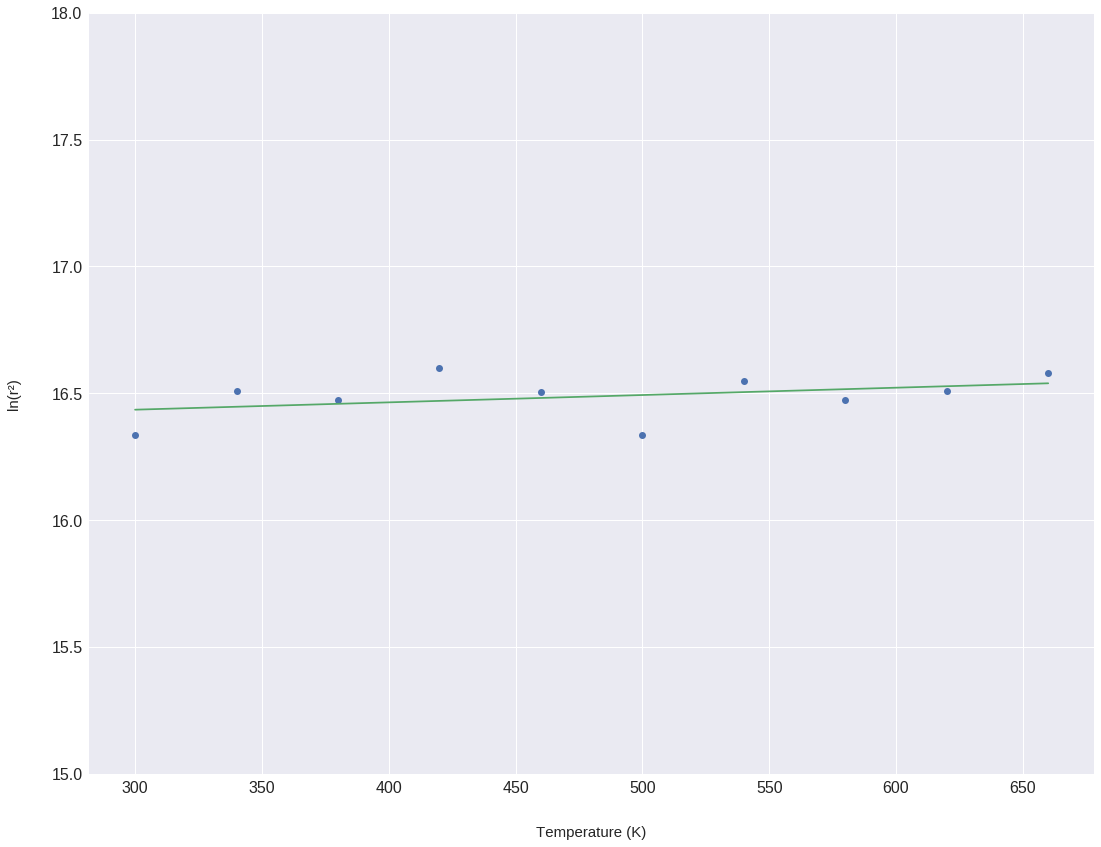

In [19]:
fig = plt.figure(figsize=(18, 14))
ax = plt.subplot(111)
ax.set_xlabel('Temperature (K)', labelpad=30)
ax.set_ylabel('ln(r²)', labelpad=30)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
slope, intercept, r_value, p_value, std_err = stats.linregress(temp_r, avg_r)
print("Slope of fitted line:", slope)
print("Intercept of fitted line:", intercept)
line = (slope * np.array(temp_r)) + intercept
ax.plot(temp_r, avg_r, 'o', temp_r, line)

ax.set_autoscaley_on(False)
ax.set_ylim([15, 18])
plt.show()

In [21]:
def generateChains(nc, na, i):
    chains = []
    cn = [1, 0, 0]
    l = bl['si-o']
    p2_ = np.array([0, 0, l])
    p1_ = np.array([0, 0, 0])
    p3_ = np.array([0, l*sin(rad(37)), (l*cos(rad(37))) + l])
    for j in range(nc):
        p1 = p1_
        p2 = p2_
        p3 = p3_
        next_state = 0
        chain = [p1, p2, p3]
        for i in range(3, na):
            newp = calc_cordinates(p1, p2, p3, next_state, ba[i%2])
            chain.append(newp)
            p1 = p2
            p2 = p3
            p3 = newp
            next_state = getNextState(i, next_state)
            cn[next_state] += 1
        chains.append(chain)
    return (chains, cn)
chains = []

num_process = 2
p = Pool(num_process)
async_results = []
for i in range(num_process):
    async_results.append(p.apply_async(generateChains, (int(num_chains/num_process), num_atoms, i)))
for res in async_results:
    ch, cn = res.get()
    chains += ch
    print(cn)
    counter = list(map(sum, zip(counter,cn)))

for res in async_results:
    ch, cn = res.get()
    chains += ch
    print(cn)
    counter = list(map(sum, zip(counter,cn)))

[3438, 714, 699]
[3365, 759, 727]
[3438, 714, 699]
[3365, 759, 727]


Total Chains: 100


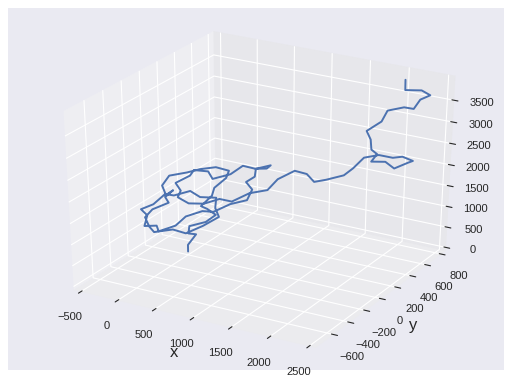

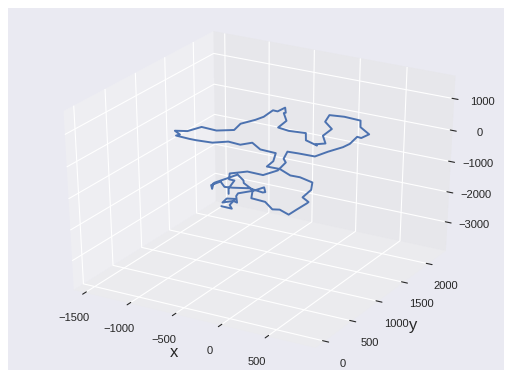

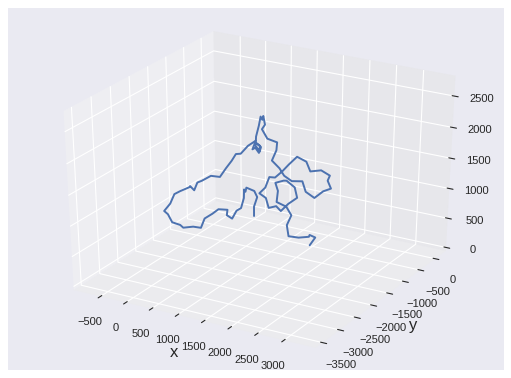

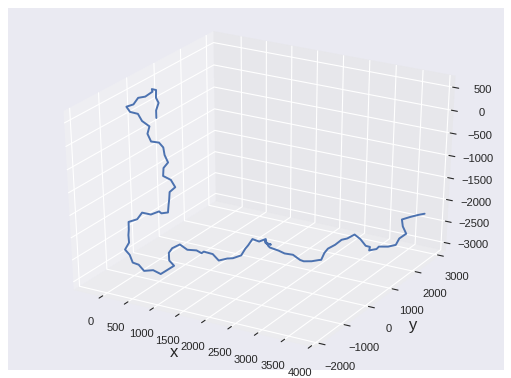

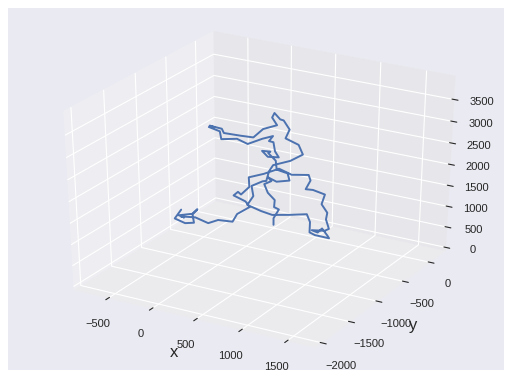

In [22]:
#@title Polymer Chain Plot

def plot_polymer_chain(chain):
  fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k',)
  ax = plt.axes(projection='3d')
  ax.plot(chain[:,0], chain[:,1], chain[:,2], label='polymer chain')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
#   ax.set_autoscaley_on(False)
#   ax.set_xlim([0,100])
#   plt.zlabel('z')

print("Total Chains:", num_chains)
for chain in chains[int((num_chains/2)):int((num_chains/2)+5)]:
  plot_polymer_chain(np.array(chain))